# 6 day test run for multilevel `m12` for new SeaFlow dataset
 * running for first 4 days of dataset
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## global switches and settings

In [1]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF output file (set to None to not save output)
savename_output = 'data_exp_zs_20200918_multilevel_seaflow6day_m12.nc'

# save the Stan output instead a few stats (only active if filename is specified above)
save_stan_output = True

# specify the Stan variable names to save; if set to None, all variables are saved 
# (only active if save_stan_output is True)
varnames_save = None

# the number of tries to fit each Stan model to achieve an R-hat < 1.1
num_tries = 3

# the prior_only option passed to each Stan model
prior_only = False

## load data from files and plot

In [2]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

# load data
datafiles = {
    #'seaflow':'data/SeaFlow_PSD_hourlyCOUNT_v3_regrid-25-8_day1to8.nc',
    'seaflow':'data/SeaFlow_PSD_hourlyCOUNT_v3_regrid-25-8_day2to7.nc',
    #'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]

    # create "counts" entry
    if 'count' not in data_gridded[dataname]:
        raise RuntimeError('Cannot find a "count" entry in "{}".'.format(datafiles[dataname]))
        
    data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    
    # add description
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

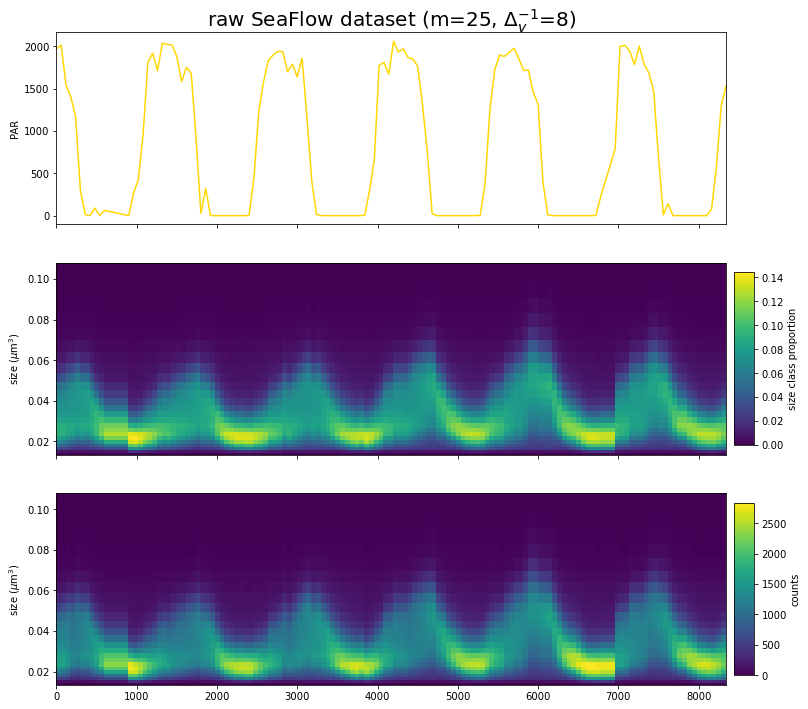

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if show_data:
    for i,dataname in enumerate(data_gridded):
        nrows = 3

        v_min = data_gridded[dataname]['v_min']
        delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('raw '+desc[dataname], size=20)
        ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
        ax.set(ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['w_obs'], shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['counts'], shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [4]:
# prepare data for Stan model

seaflow_filter_par = False

if 'data' not in globals():
    data = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = None
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        if limit_days is None:
            limit_days = int(np.ceil(data[dataname]['t_obs'][-1]/1440))
        
        if seaflow_filter_par:
            # median filter PAR
            # see: medianfilter_par.ipynb
            n = len(data_gridded[dataname]['PAR'])
            wsh = 30 # half of median filter window size; window size is 2*wsh+1
            par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
        else:
            par = data_gridded[dataname]['PAR']
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        
        if not np.all(ind_obs):
            print('{}: limit_days is set to {}, removing {}/{} observation times'.format(dataname, limit_days, ind_obs.size-np.count_nonzero(ind_obs), ind_obs.size))
        
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    if use_testdata:
        # load cross-validation testing indices and add them to data
        data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
        # remove last index, so that dimensions agree
        data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    else:
        # set all indices to zero
        data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
        
    # switch on or off data fitting
    data[dataname]['prior_only'] = int(prior_only)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

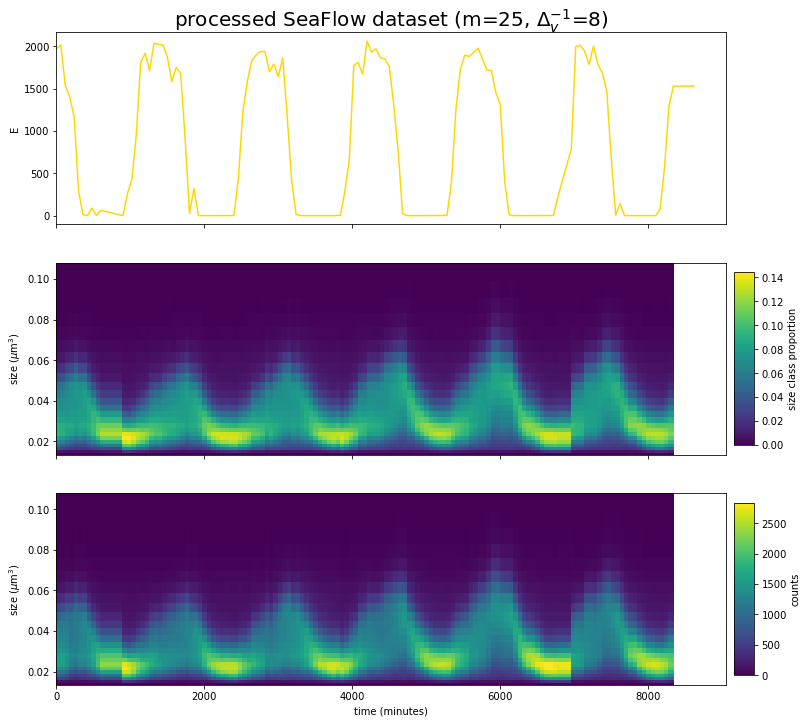

In [5]:
if show_data:
    for i,dataname in enumerate(data):
        nrows = 3

        v_min = data[dataname]['v_min']
        delta_v = 1.0/data[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
        t = np.arange(data[dataname]['nt'])*data[dataname]['dt']


        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('processed '+desc[dataname], size=20)
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(ylabel='E')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, data[dataname]['obs'], shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
        ax.set_xlim(left=0.0)

        ax = axs[2]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, data[dataname]['obs_count'], shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
        ax.set_xlim(left=0.0)
    axs[-1].set_xlabel('time (minutes)')
None

## run model

In [6]:
desc_model = {
    #'m1':'m1',
    #'m2':'m2',
    #'m3':'m3',
    #'m4':'m4',
    #'m5':'m5',
    #'m6':'m6',
    #'m7':'m7',
    #'m8':'m8',
    #'m9':'m9',
    #'m10':'m10',
    #'m11':'m11',
    'm12':'m12',
    #'m13':'m13',
    #'m14':'m14',
}
# preparing for some regular expression magic
model_code_replacements = {
    'm1':(),
    'm2':(),
    'm3':(),
    'm4':(),
    'm5':(),
    'm6':(),
    'm7':(),
    'm8':(),
    'm9':(),
    'm10':(),
    'm11':(),
    'm12':(),
    'm13':(),
    'm14':(),
}
model_stan_key = {
    'm1':'c1',
    'm2':'c2',
    'm3':'c3',
    'm4':'c4',
    'm5':'c5',
    'm6':'c6',
    'm7':'c7',
    'm8':'c8',
    'm9':'c9',
    'm10':'c10',
    'm11':'c11',
    'm12':'c12',
    'm13':'c13',
    'm14':'c14',
}
stan_files = {
    'c1':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowthvol_xval2.stan',
    'c2':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowthvol_xval2.stan',
    'c3':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c4':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowthvol_xval2.stan',
    'c5':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowthvol_xval2.stan',
    'c6':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowthvol_xval2.stan',
    'c7':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowthvol_xval2.stan',
    'c8':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowthvol_xval2.stan',
    'c9':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowthvol_xval2.stan',
    'c10':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowthvol_xval2.stan',
    'c11':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c12':'stancode/multilevel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
    'c13':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c14':'stancode_gallery2/trackvol_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
}

In [7]:
import pystan
import re
import time

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'models' not in globals():
    models = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'maxrhats' not in globals():
    maxrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}
if 'num_tries' not in globals():
    num_tries = 3
    
try_again = True
refit_all = False

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in desc_model:
    code_split = stan_base_code[model_stan_key[model]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[model]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(model, line_new))
        code_split_new.append(line_new)
                
    stan_code[model] = '\n'.join(code_split_new)

for model in desc_model:
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model], model_name=model, obfuscate_model_name=False)

# run a bunch of experiments -- this may take a while
for model in models:
    if model not in maxrhats:
        maxrhats[model] = {}
    if model not in sampling_time:
        sampling_time[model] = {}
    for dataname in data:
        if dataname not in maxrhats[model]:
            maxrhats[model][dataname] = []
        if dataname not in sampling_time[model]:
            sampling_time[model][dataname] = []
        if model in mcmcs:
            if dataname in mcmcs[model] and not refit_all and not refit_required[model]:
                print('{}: found existing results:'.format(model))
                print('{} ({})'.format(model, desc_model[model])) 
                print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if '[' not in x or 'rho_max' in x or 'delta_max' in x or 'gamma_max' in x or 'E_star' in x or 'daily' in x))
                rhat_max = get_max_rhat(mcmcs[model][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(model,rhat_max))
                else:
                    print('{}: not re-running model'.format(model))
                    print()
                    continue
            elif refit_all:
                print('{}: refit_all is active, re-running model'.format(model))
            elif refit_required[model]:
                print('{}: change in model code requires re-running model'.format(model))
        else:
            mcmcs[model] = {}
        for itry in range(num_tries):
            t0 = time.time()
            mcmcs[model][dataname] = models[model].sampling(data=data[dataname], iter=2000)
            sampling_time[model][dataname].append(time.time() - t0) # in seconds
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[model][dataname])
            maxrhats[model][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/{} found Rhat={:.3f}, trying again'.format(model, itry+1, num_tries, rhat_max))
        print('{} ({})'.format(model, desc_model[model])) 
        print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if '[' not in x or 'rho_max' in x or 'delta_max' in x or 'gamma_max' in x or 'E_star' in x or 'daily' in x))
        print()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m12 NOW.


m12: compiling


/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmplyy5uuqg/stanfit4m12_8189950041843291851.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


m12 (m12)
Inference for Stan model: m12.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max_mu          50.12    0.16   5.71  39.13  46.36  50.05  53.95  61.21   1240    1.0
delta_max_sigma        8.18    0.13   5.07    3.2   5.18   6.85   9.43  21.84   1632    1.0
delta_max[1]          45.14    0.15   4.53  36.52  41.93  45.13  48.19  54.19    861    1.0
delta_max[2]          61.65    0.22   5.92  49.66  57.43  61.97  66.38  71.42    758    1.0
delta_max[3]           52.7    0.19    5.2  42.72  49.15  52.59  56.35  62.82    752    1.0
delta_max[4]          48.62    0.17   4.81  39.44  45.31  48.55  51.95  58.16    807    1.0
delta_max[5]          54.07    0.19   5.18  44.05  50.46   54.0  57.75   64.1    734    1.0
delta_max[6]          51.57    0.18   5.02  41.84  48.05  51.49  55.13   61.3    760    1.0
gamma_max_mu 

## plot the results

In [8]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# set the color for each model
num_model = len(mcmcs)
if num_model <= 10:
    colors_model = {model:'C{}'.format(imodel) for imodel,model in enumerate(mcmcs)}
else:
    colors_model = {model:mpl.cm.viridis(imodel/(num_model-1)) for imodel,model in enumerate(mcmcs)}
    
maxrhats_final = {model:{dataname:get_max_rhat(mcmcs[model][dataname]) for dataname in data} for model in mcmcs}

In [9]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

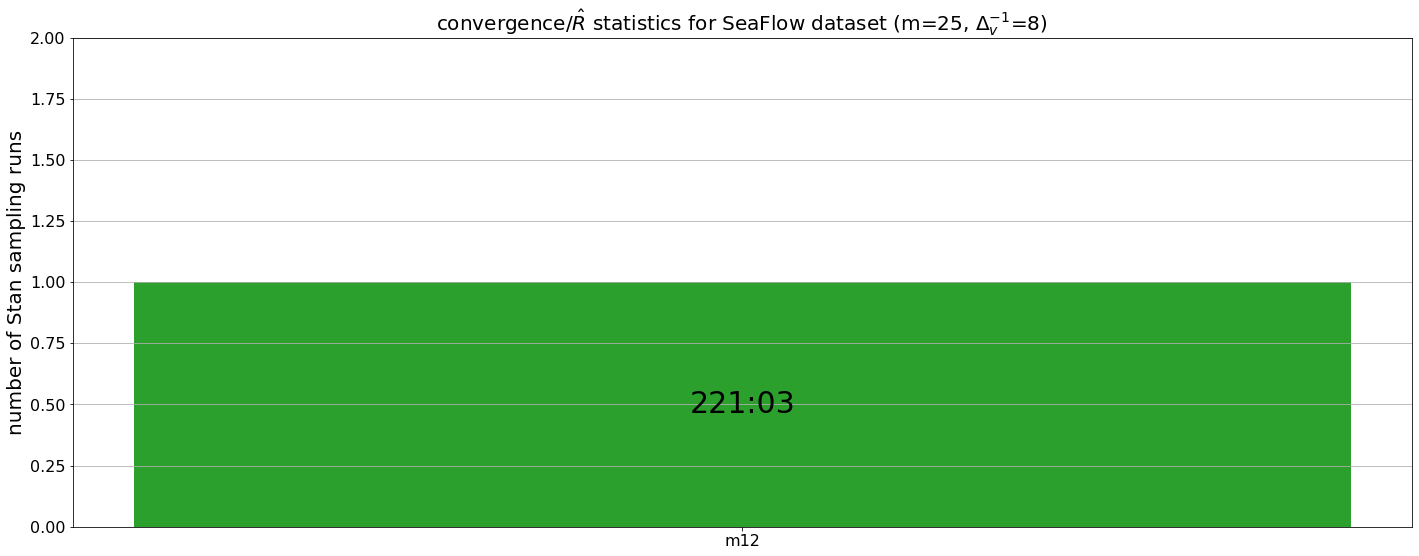

In [10]:
ylim_top = 0
for dataname in data:
    for model in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[model][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), squeeze=False, sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,model in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[model][dataname])
        height_good = len(maxrhats[model][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        
        if len(sampling_time[model][dataname]) != height_bad+height_good:
            print('{}, {}: Timing information inconsistent.'.format(dataname, desc_model[model]))
        else:
            for it, t in enumerate(sampling_time[model][dataname]):
                ax.text(x, it+0.5, '{:.0f}:{:02.0f}'.format(t//60, t%60), ha='center', va='center', size=30)
            
        xticks.append(x)
        xticklabels.append(desc_model[model].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

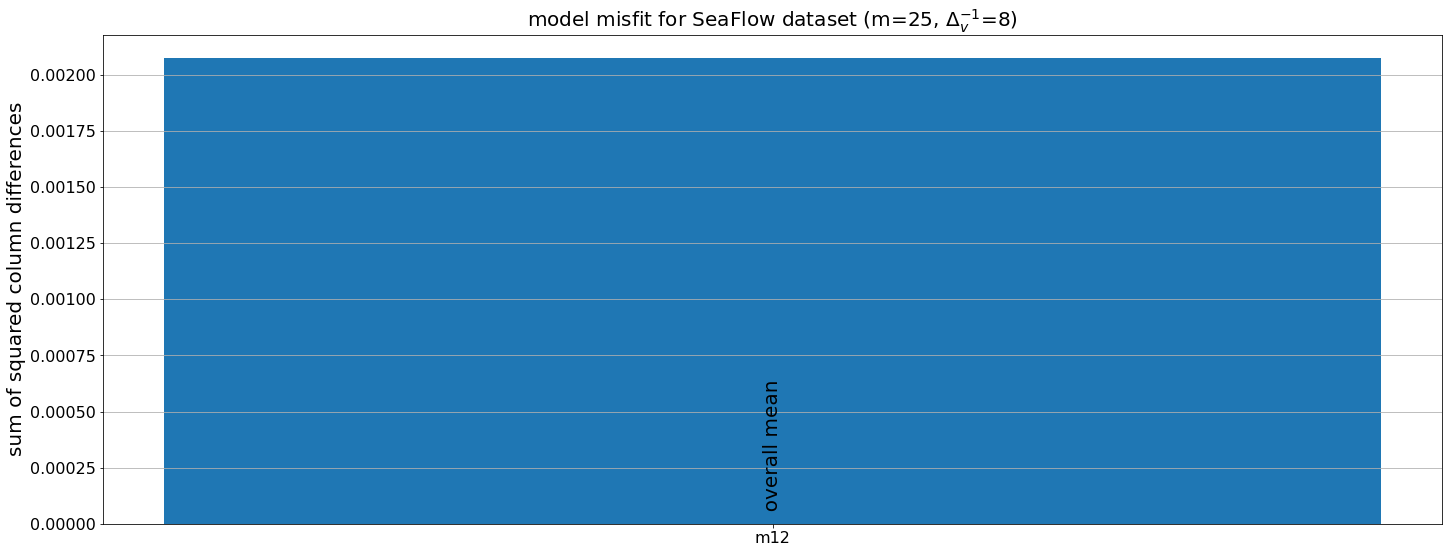

In [11]:
# updated code can handle all data[dataname]['i_test'] == 0 and draw only a single bar
if np.all(data[dataname]['i_test'] == 0):
    num_bars = 1
else:
    num_bars = 3

height = np.zeros(num_bars)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,model in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[model][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[model],e)
        
        height[0] = np.mean(e)
        if num_bars > 1:
            height[1] = np.mean(e[data[dataname]['i_test'] == 0])
            height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = (num_bars+1)*i+np.arange(num_bars)
        ax.bar(x=x, height=height, color=colors_model[model])
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[model][dataname] > 1.1:
            ax.text(x[num_bars//3], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[num_bars//3])
        xticklabels.append(desc_model[model].replace(',',',\n').replace('(','\n('))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

In [12]:
add_labels = True
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(14,14))
        ax.set_title(desc[dataname], size=20)
        
        for model in mcmcs:
            # misfit to data

            obs = data[dataname]['obs']

            tmp = mcmcs[model][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            if np.all(data[dataname]['i_test'] == 0):
                e0 = np.mean(np.sum(tmp, axis=1), axis=1)
                xlabel_suffix = ''
            else:
                e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                xlabel_suffix = ' (test data)'
            
            # misfit to division rate

            e1 = np.abs(mcmcs[model][dataname]['divrate'] - reference_values[dataname]['divrate'])
        
            q0 = np.percentile(e0, q=(5,25,50,75,95))
            q1 = np.percentile(e1, q=(5,25,50,75,95))
            
            eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
            ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
            
            if add_labels:
                ax.text(q0[2], q1[2], ' '+desc_model[model], color=eb[0].get_color(), size=20)
            
            if maxrhats_final[model][dataname] > 1.1:
                ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
        ax.grid(True)
        ax.legend()
        ax.set(xlabel='size distribution misfit'+xlabel_suffix, ylabel='daily division rate misfit')
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)

In [13]:
datanames = tuple(data.keys())
if len(datanames) > 1:
    fig, ax = plt.subplots(figsize=(14,14))

    for model in mcmcs:
        qq = {}
        # misfit to data
        for dataname in datanames:
            obs = data[dataname]['obs']

            tmp = mcmcs[model][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2

            if np.all(data[dataname]['i_test'] == 0):
                e0 = np.mean(np.sum(tmp, axis=1), axis=1)
            else:
                e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)

            qq[dataname] = np.percentile(e0, q=(5,25,50,75,95))

        q0 = qq[datanames[0]]
        q1 = qq[datanames[1]]

        eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
        ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
        if maxrhats_final[model][dataname] > 1.1:
            ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)

    ax.grid(True)
    ax.legend()
    ax.set(xlabel='{} size distribution misfit'.format(desc[datanames[0]]), 
           ylabel='{} size distribution misfit'.format(desc[datanames[1]]))
    ax.set_xlim(left=0.0)
    ax.set_ylim(bottom=0.0)
None

In [14]:
data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')
t_zinser = data_fig2a['exper time'] * 60
ab_mean_norm = 0.5*(data_fig2a['cells A'].values/data_fig2a['cells A'].values[0] + 
                    data_fig2a['cells B'].values/data_fig2a['cells B'].values[0])

add_labels = True
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(14,14))
        ax.set_title(desc[dataname], size=20)
        
        for model in mcmcs:
            # make sure the time is right, if not implement something fancier
            assert all(t_zinser.values[:-1] == data[dataname]['t_obs'])
            
            # misfit to normalized abundance
            
            e0 = np.mean(np.abs(np.sum(mcmcs[model][dataname]['mod_obspos'], axis=1)[:,1:]-ab_mean_norm[1:-1]), axis=1)
            
            # misfit to division rate

            e1 = np.abs(mcmcs[model][dataname]['divrate'] - reference_values[dataname]['divrate'])
        
            q0 = np.percentile(e0, q=(5,25,50,75,95))
            q1 = np.percentile(e1, q=(5,25,50,75,95))
            
            eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
            ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
            if add_labels:
                ax.text(q0[2], q1[2], ' '+desc_model[model], color=eb[0].get_color(), size=20)
            if maxrhats_final[model][dataname] > 1.1:
                ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
        ax.grid(True)
        ax.legend()
        ax.set(xlabel='normalized abundance misfit (hourly division rate)', ylabel='daily division rate misfit')
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


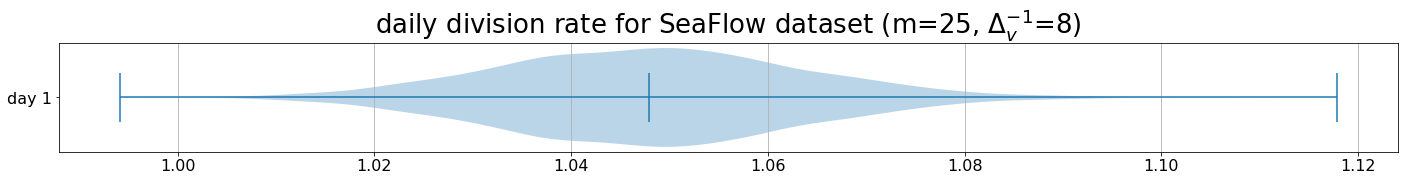

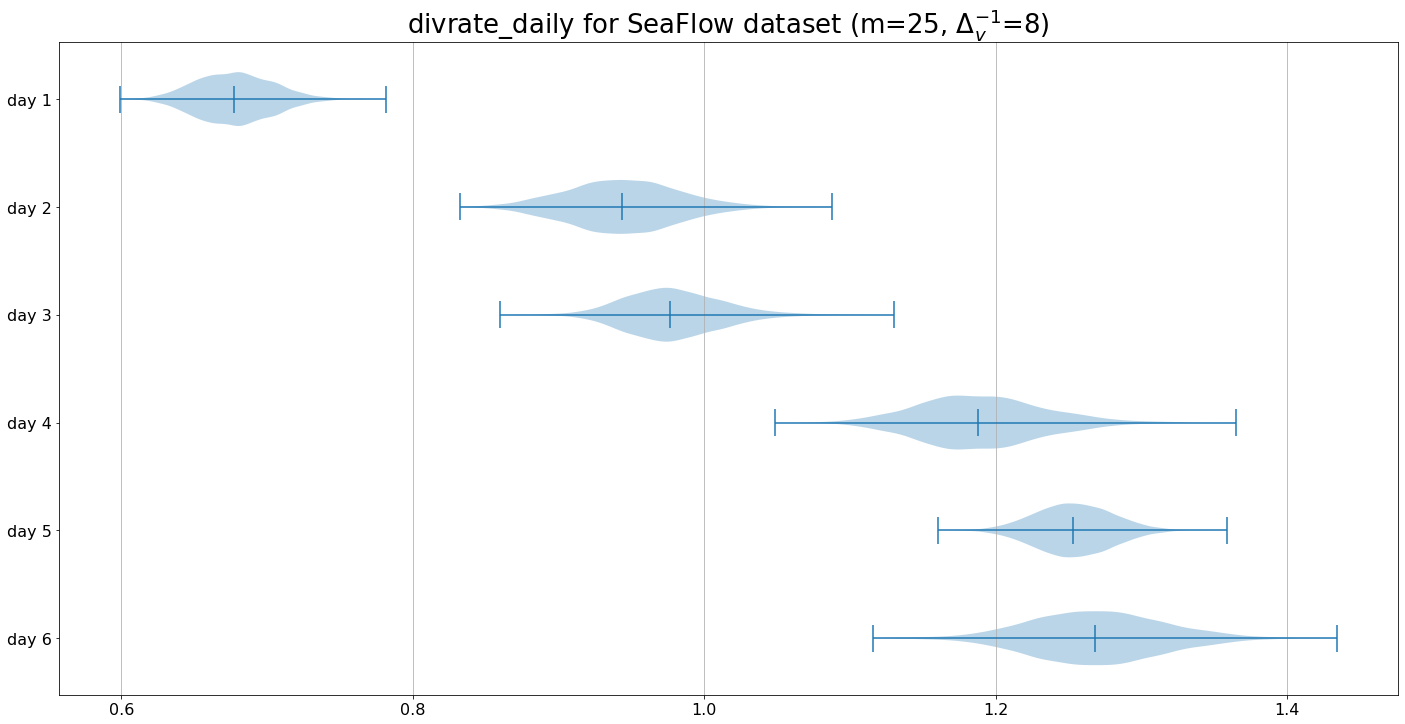

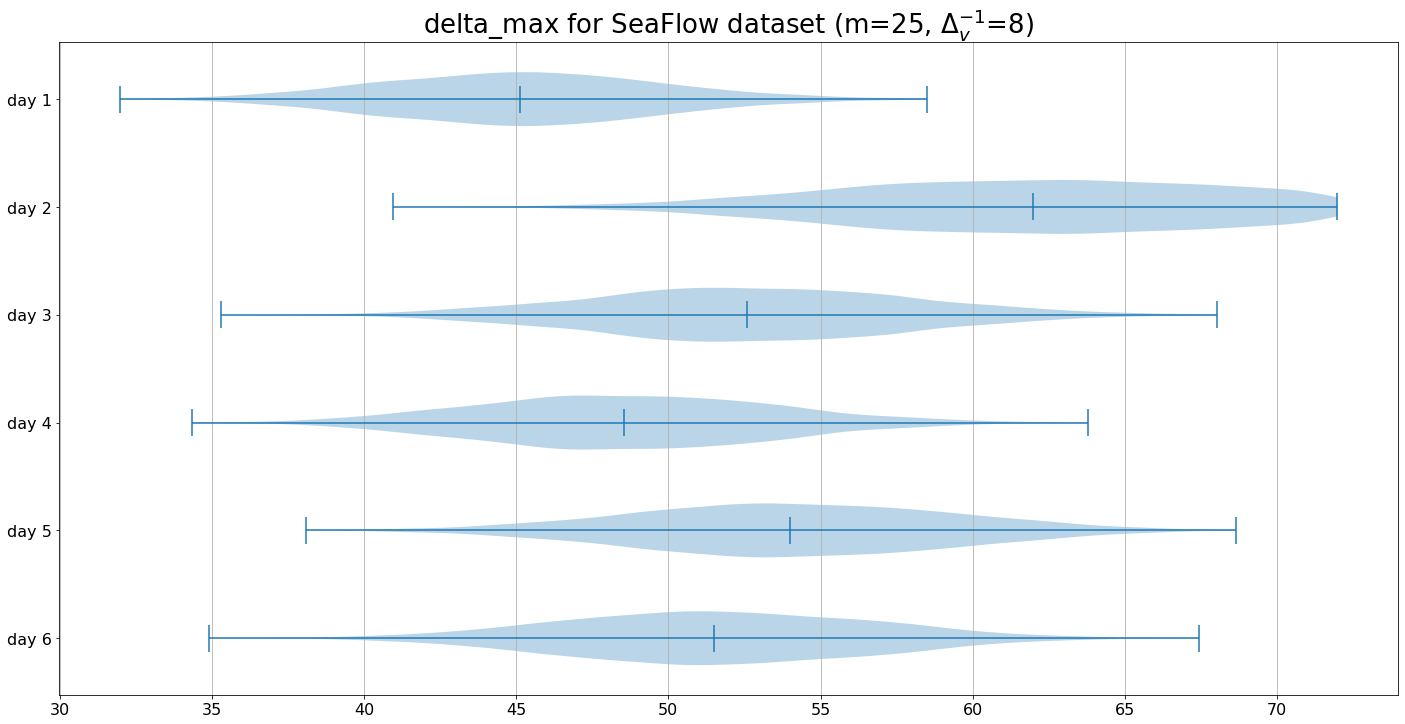

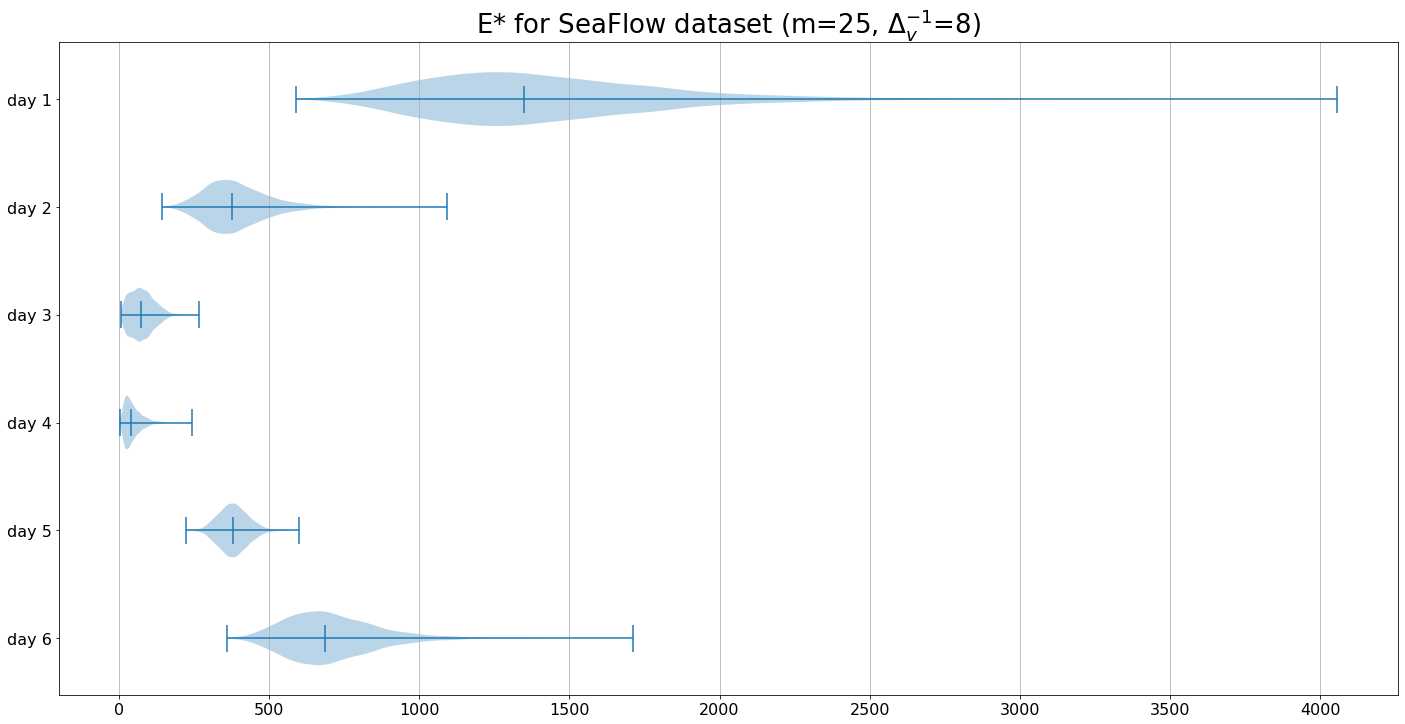

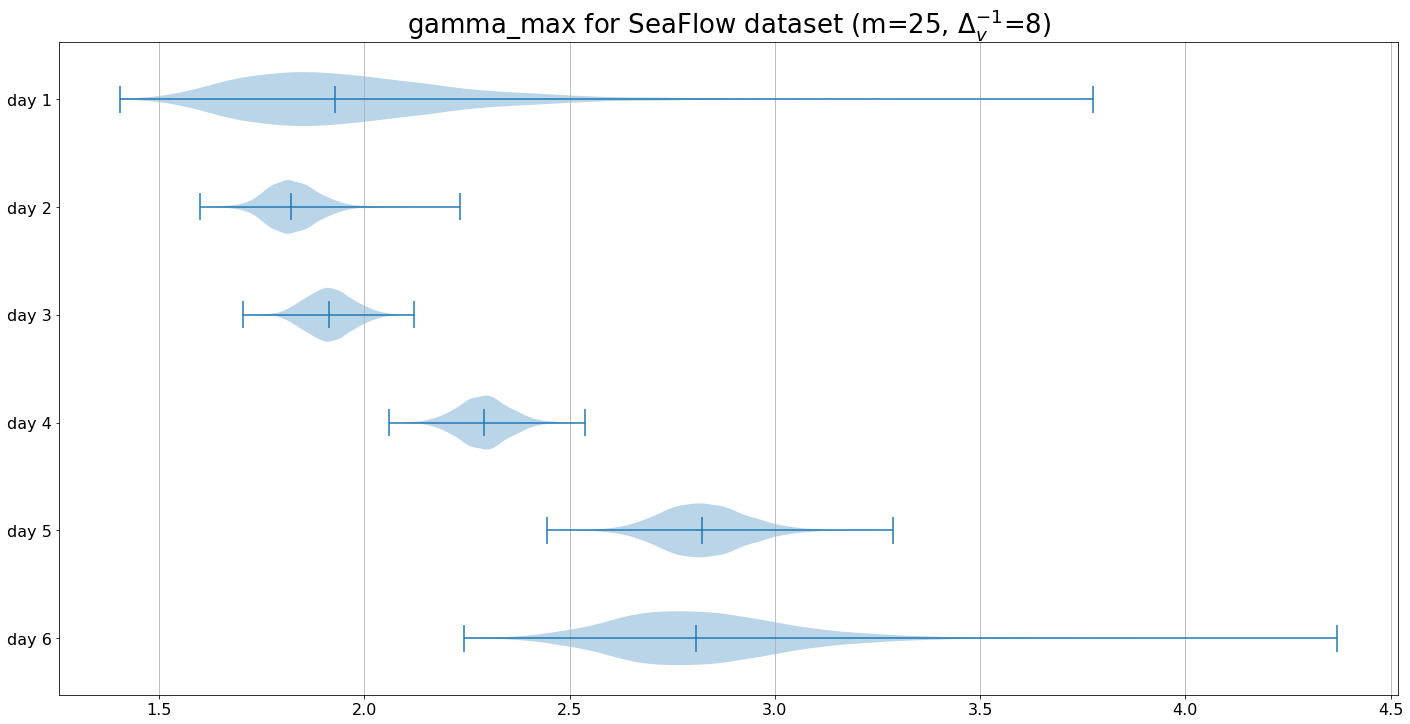

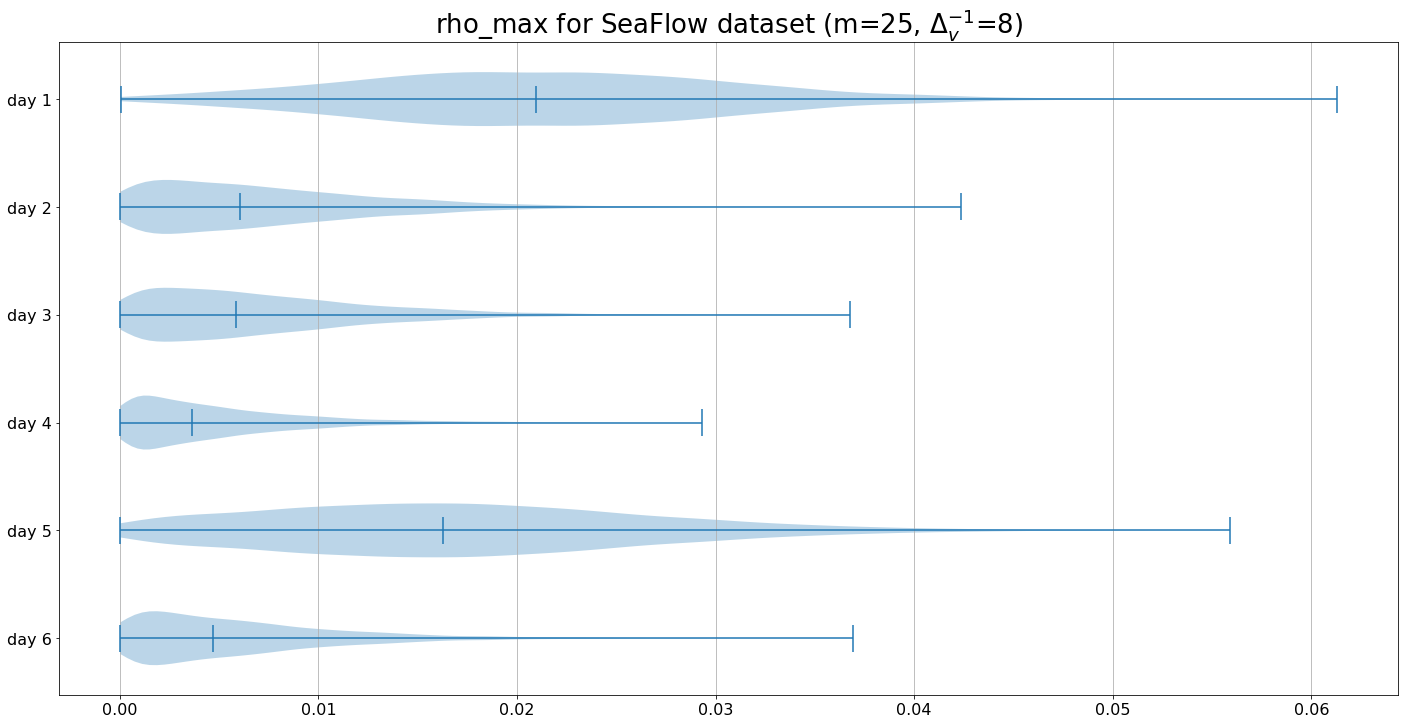

In [15]:
for param in ('divrate', 'divrate_daily', 'delta_max', 'E_star', 'gamma_max', 'rho_max'):
    for dataname in data:
        num_mcmcs = len(mcmcs)
        for model in mcmcs:
            if mcmcs[model][dataname][param].ndim > 1:
                num_p = mcmcs[model][dataname][param].shape[1]
            else:
                num_p = 1
            fig, ax = plt.subplots(figsize=(24,2*num_p))
            if param in param_desc:
                ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
            else:
                ax.set_title('{} for {}'.format(param, desc[dataname]))
            ax.violinplot(mcmcs[model][dataname][param], showmedians=True, vert=False)
            ax.invert_yaxis()
            ax.grid(axis='x')
            ax.set(yticks=np.arange(1,num_p+1), yticklabels=['day {}'.format(i+1) for i in range(num_p)])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        for i,model in enumerate(mcmcs):
            if maxrhats_final[model][dataname] > 1.1:
                ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

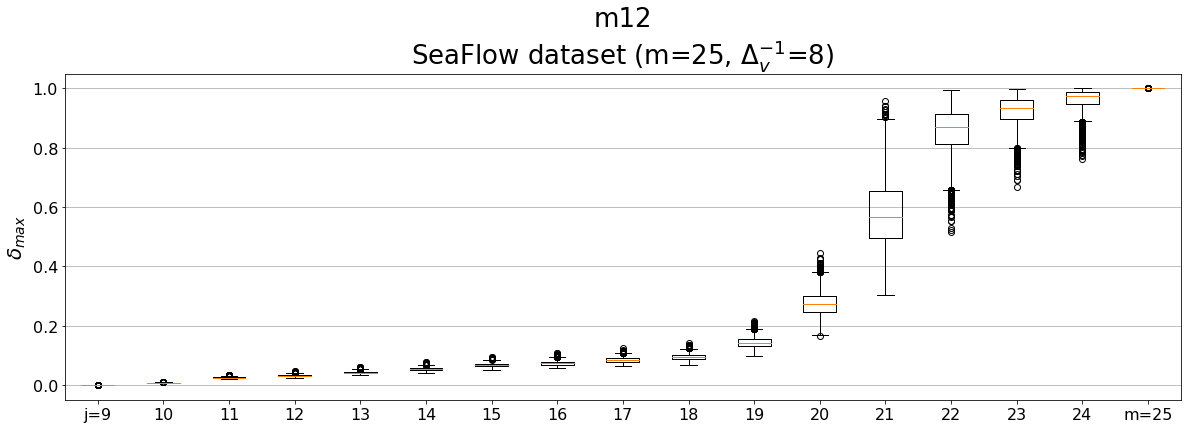

In [16]:
for dataname in data:
    for model,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[model] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[model][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

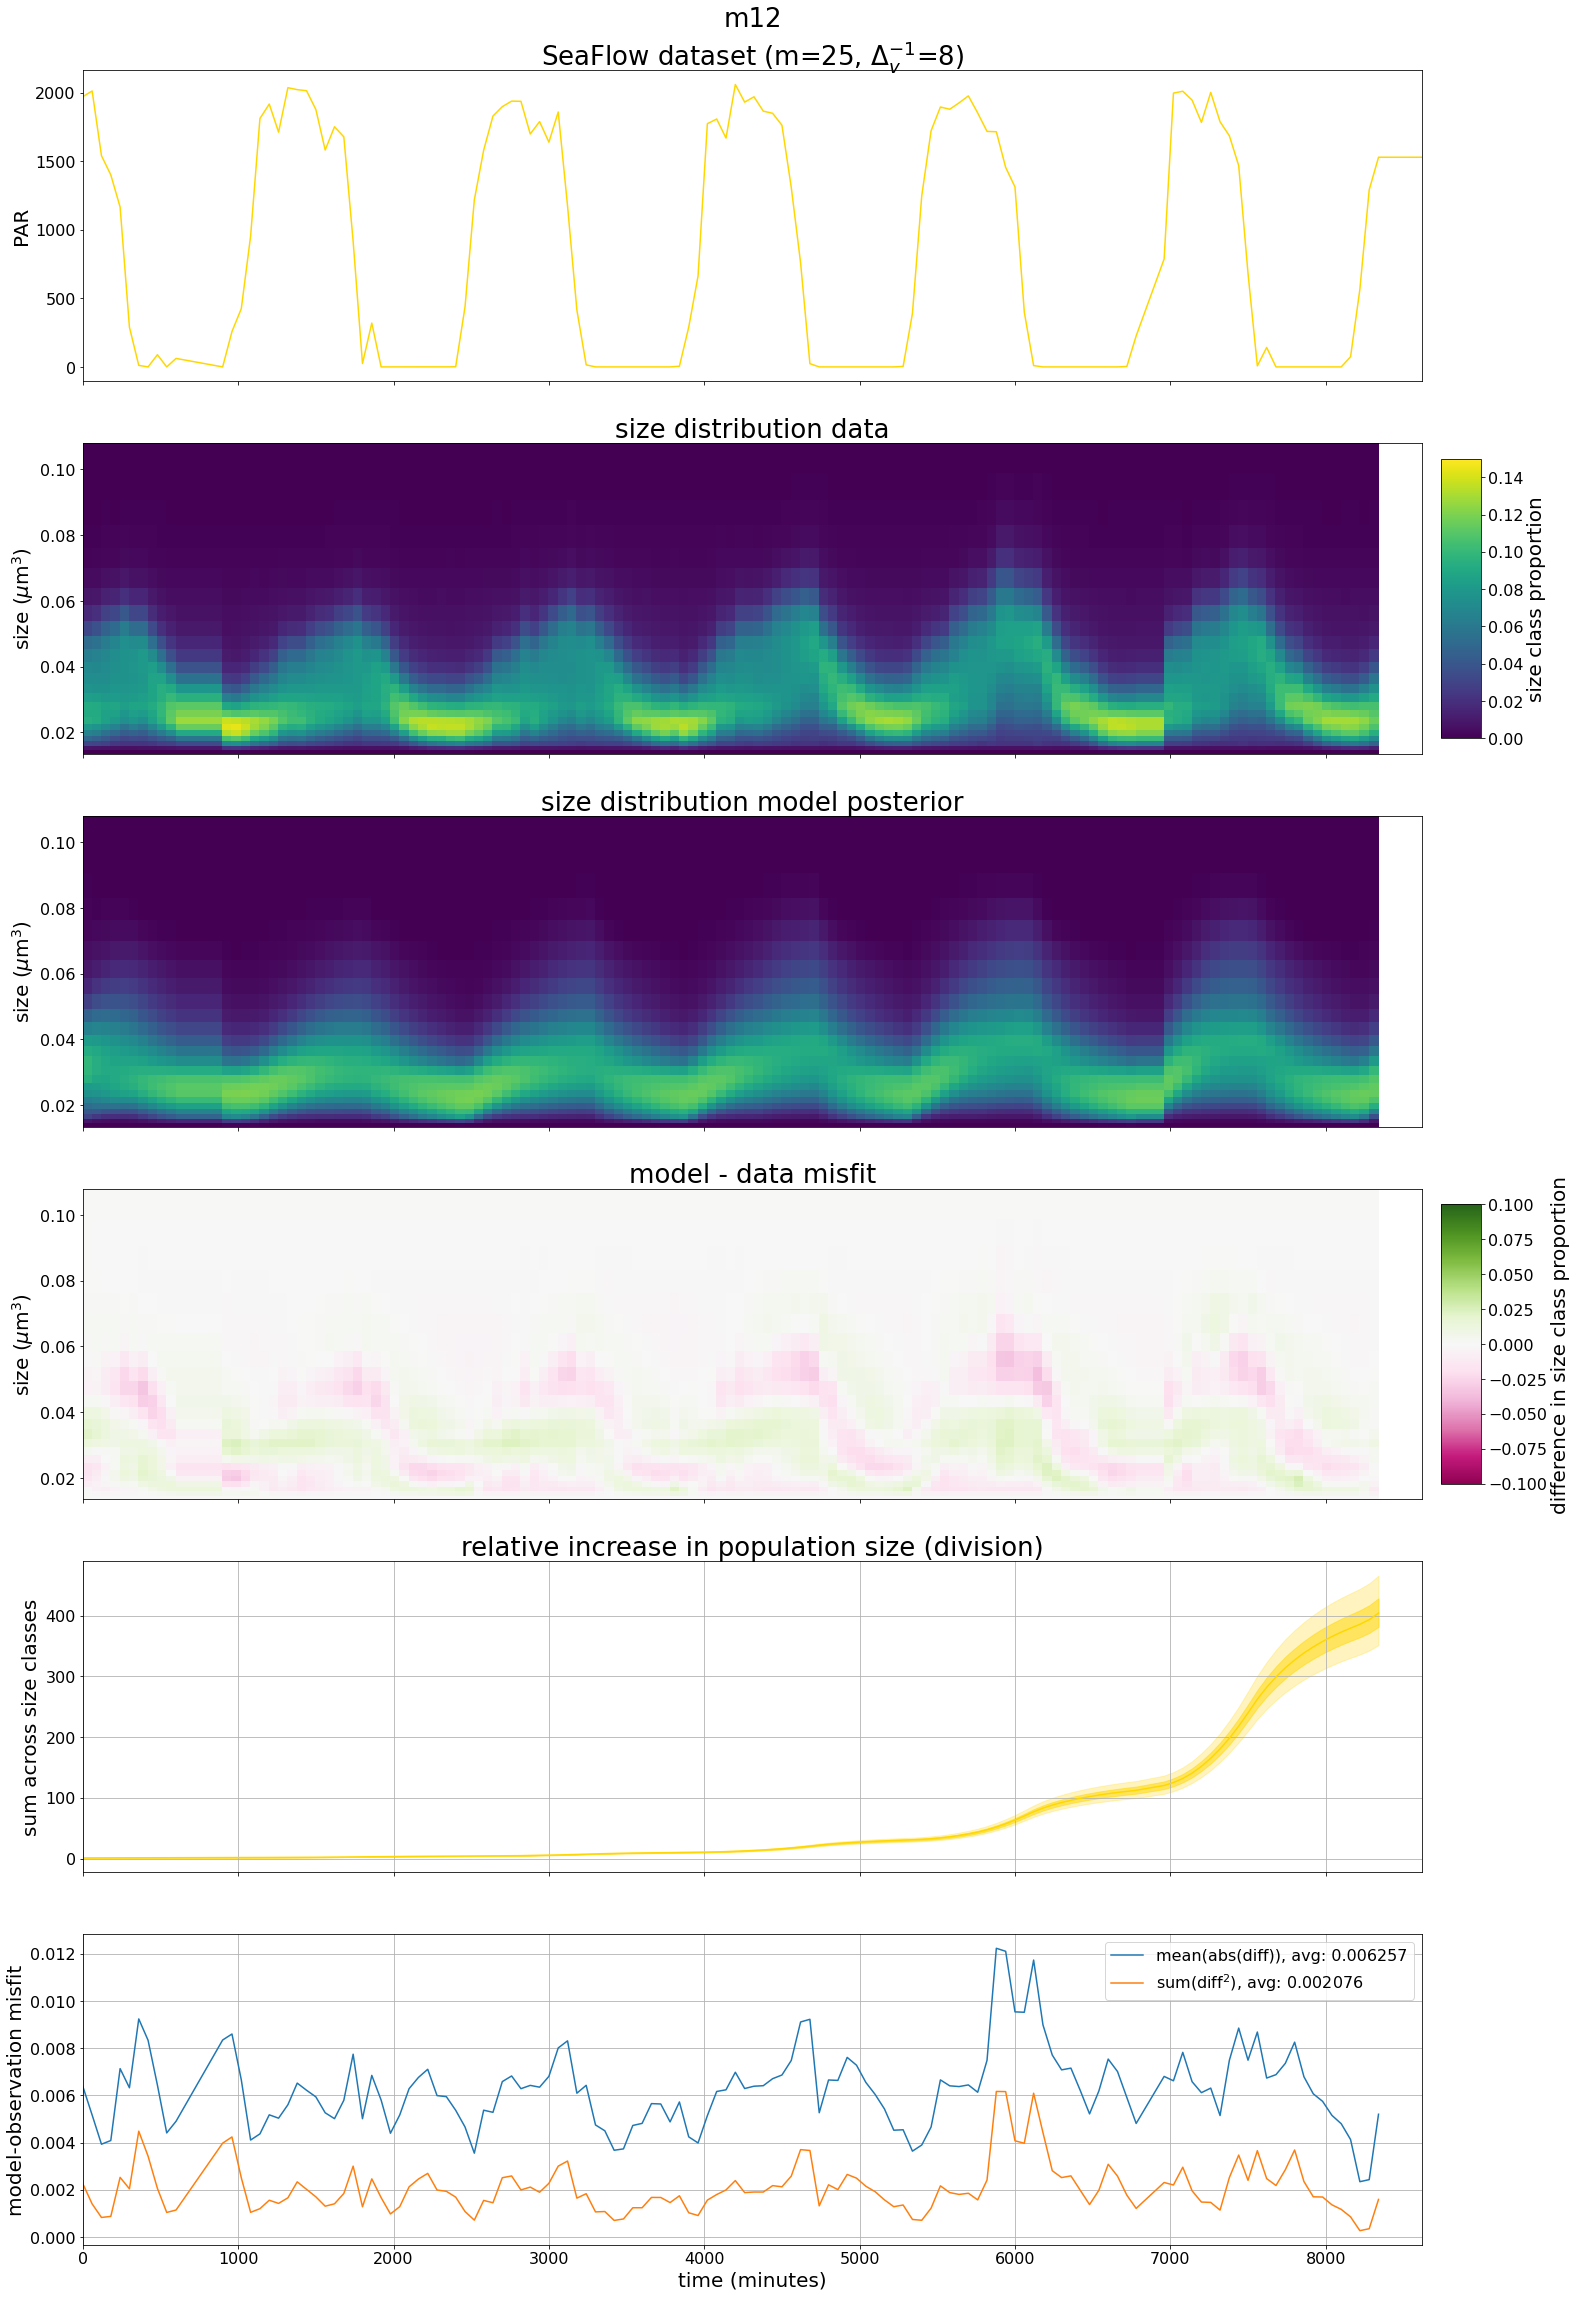

In [17]:
data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.15)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
    v = v_ext[:-1]
    v_width = v_ext[1:] - v_ext[:-1]
        
    for model,mcmc in mcmcs.items():
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[model][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[model] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[model] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, res['obs'],norm=norm, shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, res_sum1,norm=norm, shading='auto')

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, diff,norm=norm_diff, cmap='PiYG', shading='auto')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()

In [18]:
if 'varnames_save' not in globals():
    varnames_save = None

save_only_converged = True

if savename_output is not None:    
    with nc4.Dataset(savename_output, 'w') as nc:
        for dataname in data:
            ncg = nc.createGroup(dataname)

            if save_stan_output:
                dimensions = {
                    'obstime':int(data[dataname]['nt_obs']),
                    'time':int(data[dataname]['nt']),
                    'sizeclass':int(data[dataname]['m']),
                    'm_minus_j_plus_1':int(data[dataname]['m']-data[dataname]['delta_v_inv']),
                }
                dimensions_inv = {v:k for k,v in dimensions.items()}
                for d in dimensions:
                    ncg.createDimension(d, dimensions[d])
                    
                ncg.createVariable('time', int, ('time',))
                ncg.variables['time'][:] = int(data[dataname]['dt']) * np.arange(data[dataname]['nt'])
                ncg.variables['time'].units = 'minutes since start of experiment'
                
                ncg.createVariable('obstime', int, ('obstime',))
                ncg.variables['obstime'][:] = data[dataname]['t_obs'].astype(int)
                ncg.variables['obstime'].units = 'minutes since start of experiment'
                ncg.variables['obstime'].long_name = 'time of observations'

                for v in ('dt', 'm', 'v_min', 'delta_v_inv', 'obs', 'i_test', 'E', 'obs_count'):
                    if isinstance(data[dataname][v], int):
                        ncg.createVariable(v, int, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                    elif isinstance(data[dataname][v], float):
                        ncg.createVariable(v, float, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                    else:
                        dims = tuple(dimensions_inv[d] for d in data[dataname][v].shape)
                        ncg.createVariable(v, data[dataname][v].dtype, dims, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                
                for imodel,model in enumerate(mcmcs):
                    if save_only_converged and get_max_rhat(mcmcs[model][dataname]) > 1.1:
                        logging.warning('Model "{}" did not converge -- skipping.'.format(model))
                        continue
                    ncm = ncg.createGroup(model)
                    
                    dimensions['sample'] = mcmcs[model][dataname]['mod_obspos'].shape[0]
                    dimensions_inv[dimensions['sample']] = 'sample'
                    ncm.createDimension('sample', dimensions['sample'])
                    if mcmcs[model][dataname]['E_star'].ndim == 2:
                        dimensions['day'] = mcmcs[model][dataname]['E_star'].shape[1]
                        dimensions_inv[dimensions['day']] = 'day'
                        ncm.createDimension('day', dimensions['day'])
                    if 'tau[1]' in mcmcs[model][dataname].flatnames:
                        dimensions['tau'] = mcmcs[model][dataname]['tau'].shape[1]
                        dimensions_inv[dimensions['tau']] = 'tau'
                        ncm.createDimension('tau', dimensions['tau'])
                    
                    # write model description
                    ncm.setncattr('description', desc_model[model])
                    ncm.setncattr('code', stan_files[model_stan_key[model]])
                    
                    varnames = set(v.split('[')[0] for v in mcmcs[model][dataname].flatnames)
                    if varnames_save is None:
                        varnames_curr = varnames
                    else:
                        varnames_curr = varnames_save
                        
                    for v in varnames_curr:
                        if v in varnames:
                            dims = tuple(dimensions_inv[d] for d in mcmcs[model][dataname][v].shape)
                            ncm.createVariable(v, float, dims, zlib=True)
                            ncm.variables[v][:] = mcmcs[model][dataname][v]
                        else:
                            logging.warning('Cannot find variable "{}" for model "{}".'.format(v, model))
            else:
                for i,model in enumerate(mcmcs):
                    if i == 0:
                        ncg.createDimension('model', len(mcmcs))
                        ncg.createDimension('sample', mcmcs[model][dataname]['divrate'].shape[0])

                        ncg.createVariable('divrate', float, ('model','sample'))
                        ncg.createVariable('sumsqdiff', float, ('model','sample'))
                        ncg.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')

                    ncg.variables['divrate'][i,:] = mcmcs[model][dataname]['divrate']

                    obs = data[dataname]['obs']

                    tmp = mcmcs[model][dataname]['mod_obspos']
                    tmp/= np.sum(tmp, axis=1)[:,None,:]
                    tmp -= obs[None,:,:]
                    tmp **= 2

                    if np.all(data[dataname]['i_test'] == 0):
                        ncg.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp, axis=1), axis=1)
                        if i == 0:
                            ncg.variables['sumsqdiff'].setncattr('data_used', 'all data')
                    else:
                        nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                        if i == 0:
                            ncg.variables['sumsqdiff'].setncattr('data_used', 'testing data')

                    for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                        if i == 0:
                            ncg.createVariable(v, float, ('model','sample'))
                        if v in mcmcs[model][dataname].flatnames:
                            ncg.variables[v][i,:] = mcmcs[model][dataname][v]